# Classificació de boscos

A partir de les dades del 'cover_type' data set entrenaré un algorisme de
ML anomenat SVC per a que classifiqui el meu target 'Cover-type' i provaré
de millorar els resultats mitjançant 'feature selection' i estudiant els
paràmetres de l'algoritme.

Per a realitzar 'feature selection' replicaré els experiments
del blog [Fantastic Trees and where to find them](https://towardsdatascience.com/predicting-forest-cover-types-with-the-machine-learning-workflow-1f6f049bf4df)
per a verificar els resultats que obté, així justificar les modificacions
que faig a les dades.

## Support Vector Classifier

Support Vector Machines són algorismes que construeixen un hiper-pla, o un
conjunt d'hiper-plans en un espai dimensional molt gran (o infinit) que
poden ser usats per fer regressions, classificacions o altres tasques.
SVC és una Support Vector Machine per a classificació (Support Vector Classifier).

Un hiper-pla és un subespai en què la seva dimensió és una menys que la
de l'espai que el conté:  en un espai de 2 dimensions seria una línia,
en un de 3 un pla, en un de quatre seria un cub...

L'objectiu, per tant, d'un SVC serà ajustar les dades, retornant l'hiper-pla
que millor divideixi o categoritzi les dades. Aquesta separació serà millor
quanta més distància hi hagi entre l'hiper-pla i el punt de les dades que
tingui més a prop.

És a dir, l'algorisme buscarà l'hiper pla marginal màxim, ajudant-se dels
'Support vectors' que són els punts de les dades més propers a l'hiper pla.
Es faran servir aquests vectors per a calcular els marges.

A partir d'aquest pla i les característiques d'un objecte podem predir
de quina classe serà l'objecte.


In [1]:
# Llibreries per manipular les dades
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_columns', 60)

import seaborn as sns
sns.set_context(font_scale=2)

# Llibreries per mostrar gràfics
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
from matplotlib import style
%matplotlib inline

# Llibreries per al model de ML
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV


Abans de carregar el dataset, entrenar l'algorisme i fer alguna predicció
o calcular la precisió il·lustraré la idea general d'aquest algorisme amb
un exemple molt senzill on només tenim 2 atributs (x i y) i un target de
2 classes:

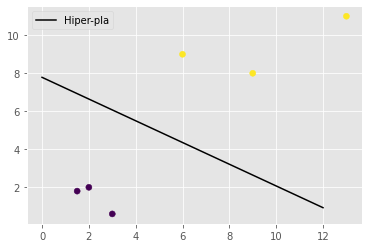

In [2]:
style.use("ggplot")

x = [2, 6, 1.5, 9, 3, 13]
y = [2, 9, 1.8, 8, 0.6, 11]

X = np.array([[2,2],
[6,9],
[1.5,1.8],
[9,8],
[3,0.6],
[13,11]])


y = [0,1,0,1,0,1]

clf = SVC(kernel='linear', probability=True, tol=1e-3)
clf.fit(X,y)

w = clf.coef_[0]

a = -w[0] / w[1]

xx = np.linspace(0,12)
yy = a * xx - clf.intercept_[0] / w[1]

h0 = plt.plot(xx, yy, 'k-', label="Hiper-pla")

plt.scatter(X[:, 0], X[:, 1], c = y)
plt.legend()
plt.show()

En el gràfic es veuen 6 punts que a simple vista podem dividir en dos
grups de 3. Per fer-ho es calcula un hiper-pla (en aquest cas una linia
per que tenim 2 dimensions només) que separa els punts, de forma que
els punts que estan per sobre del plasón d'una classe i els de sota de l'altra.


 ## 1. Carregar dataset
Agafaré els primers 15120 registres per conveniència, ja que d'aquesta forma
obtinc en mateix dataset que el que es fa servir en el blog que estic seguint:
[Fantastic Trees and where to find them](https://towardsdatascience.com/predicting-forest-cover-types-with-the-machine-learning-workflow-1f6f049bf4df)

In [3]:
soil_types = []
for i in range(0,40):
    name = "Soil_type_" + str(i+1)
    soil_types.append(name)

print(soil_types)

columnes = ["Elevation","Aspect","Slope","HDTH","VDTH","HDTR","HS9am","HSNoon",
            "HS3pm","HDTF","WA1","WA2","WA3","WA4"]
columnes += soil_types
columnes.append("Cover_type")
print(columnes)

trees = pd.read_csv("covtype.data",sep=',',header=None,names=columnes, nrows = 15120)
ids = trees.index+1
trees.insert(loc=0, column='id',value=ids)
print("Number of rows and columns in the trees dataset are:", trees.shape)

['Soil_type_1', 'Soil_type_2', 'Soil_type_3', 'Soil_type_4', 'Soil_type_5', 'Soil_type_6', 'Soil_type_7', 'Soil_type_8', 'Soil_type_9', 'Soil_type_10', 'Soil_type_11', 'Soil_type_12', 'Soil_type_13', 'Soil_type_14', 'Soil_type_15', 'Soil_type_16', 'Soil_type_17', 'Soil_type_18', 'Soil_type_19', 'Soil_type_20', 'Soil_type_21', 'Soil_type_22', 'Soil_type_23', 'Soil_type_24', 'Soil_type_25', 'Soil_type_26', 'Soil_type_27', 'Soil_type_28', 'Soil_type_29', 'Soil_type_30', 'Soil_type_31', 'Soil_type_32', 'Soil_type_33', 'Soil_type_34', 'Soil_type_35', 'Soil_type_36', 'Soil_type_37', 'Soil_type_38', 'Soil_type_39', 'Soil_type_40']
['Elevation', 'Aspect', 'Slope', 'HDTH', 'VDTH', 'HDTR', 'HS9am', 'HSNoon', 'HS3pm', 'HDTF', 'WA1', 'WA2', 'WA3', 'WA4', 'Soil_type_1', 'Soil_type_2', 'Soil_type_3', 'Soil_type_4', 'Soil_type_5', 'Soil_type_6', 'Soil_type_7', 'Soil_type_8', 'Soil_type_9', 'Soil_type_10', 'Soil_type_11', 'Soil_type_12', 'Soil_type_13', 'Soil_type_14', 'Soil_type_15', 'Soil_type_16', 

In [5]:
trees.head()

,id,Elevation,Aspect,Slope,HDTH,VDTH,HDTR,HS9am,HSNoon,HS3pm,HDTF,WA1,WA2,WA3,WA4,Soil_type_1,Soil_type_2,Soil_type_3,Soil_type_4,Soil_type_5,Soil_type_6,Soil_type_7,Soil_type_8,Soil_type_9,Soil_type_10,Soil_type_11,Soil_type_12,Soil_type_13,Soil_type_14,Soil_type_15,Soil_type_16,Soil_type_17,Soil_type_18,Soil_type_19,Soil_type_20,Soil_type_21,Soil_type_22,Soil_type_23,Soil_type_24,Soil_type_25,Soil_type_26,Soil_type_27,Soil_type_28,Soil_type_29,Soil_type_30,Soil_type_31,Soil_type_32,Soil_type_33,Soil_type_34,Soil_type_35,Soil_type_36,Soil_type_37,Soil_type_38,Soil_type_39,Soil_type_40,Cover_type
0,1,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [6]:
trees.tail()

,id,Elevation,Aspect,Slope,HDTH,VDTH,HDTR,HS9am,HSNoon,HS3pm,HDTF,WA1,WA2,WA3,WA4,Soil_type_1,Soil_type_2,Soil_type_3,Soil_type_4,Soil_type_5,Soil_type_6,Soil_type_7,Soil_type_8,Soil_type_9,Soil_type_10,Soil_type_11,Soil_type_12,Soil_type_13,Soil_type_14,Soil_type_15,Soil_type_16,Soil_type_17,Soil_type_18,Soil_type_19,Soil_type_20,Soil_type_21,Soil_type_22,Soil_type_23,Soil_type_24,Soil_type_25,Soil_type_26,Soil_type_27,Soil_type_28,Soil_type_29,Soil_type_30,Soil_type_31,Soil_type_32,Soil_type_33,Soil_type_34,Soil_type_35,Soil_type_36,Soil_type_37,Soil_type_38,Soil_type_39,Soil_type_40,Cover_type
15115,15116,2607,243,23,258,7,660,170,251,214,1282,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
15116,15117,2603,121,19,633,195,618,249,221,91,1325,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
15117,15118,2492,134,25,365,117,335,250,220,83,1187,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
15118,15119,2487,167,28,218,101,242,229,237,119,932,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3
15119,15120,2475,197,34,319,78,270,189,244,164,914,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [7]:
display(trees.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15120 entries, 0 to 15119
Data columns (total 56 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   id            15120 non-null  int64
 1   Elevation     15120 non-null  int64
 2   Aspect        15120 non-null  int64
 3   Slope         15120 non-null  int64
 4   HDTH          15120 non-null  int64
 5   VDTH          15120 non-null  int64
 6   HDTR          15120 non-null  int64
 7   HS9am         15120 non-null  int64
 8   HSNoon        15120 non-null  int64
 9   HS3pm         15120 non-null  int64
 10  HDTF          15120 non-null  int64
 11  WA1           15120 non-null  int64
 12  WA2           15120 non-null  int64
 13  WA3           15120 non-null  int64
 14  WA4           15120 non-null  int64
 15  Soil_type_1   15120 non-null  int64
 16  Soil_type_2   15120 non-null  int64
 17  Soil_type_3   15120 non-null  int64
 18  Soil_type_4   15120 non-null  int64
 19  Soil_type_5   15120 non-n

None

In [8]:
display(trees.describe())

,id,Elevation,Aspect,Slope,HDTH,VDTH,HDTR,HS9am,HSNoon,HS3pm,HDTF,WA1,WA2,WA3,WA4,Soil_type_1,Soil_type_2,Soil_type_3,Soil_type_4,Soil_type_5,Soil_type_6,Soil_type_7,Soil_type_8,Soil_type_9,Soil_type_10,Soil_type_11,Soil_type_12,Soil_type_13,Soil_type_14,Soil_type_15,Soil_type_16,Soil_type_17,Soil_type_18,Soil_type_19,Soil_type_20,Soil_type_21,Soil_type_22,Soil_type_23,Soil_type_24,Soil_type_25,Soil_type_26,Soil_type_27,Soil_type_28,Soil_type_29,Soil_type_30,Soil_type_31,Soil_type_32,Soil_type_33,Soil_type_34,Soil_type_35,Soil_type_36,Soil_type_37,Soil_type_38,Soil_type_39,Soil_type_40,Cover_type
count,15120.00000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.0,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,7560.50000,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,0.237897,0.033003,0.419907,0.309193,0.023479,0.041204,0.063624,0.055754,0.010913,0.042989,0.0,0.000066,0.000661,0.141667,0.026852,0.015013,0.031481,0.011177,0.0,0.007540,0.040476,0.003968,0.003042,0.009193,0.001058,0.022817,0.050066,0.016997,0.000066,0.003571,0.000992,0.000595,0.085384,0.047950,0.021958,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357,4.000000
std,4364.91237,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,0.425810,0.178649,0.493560,0.462176,0.151424,0.198768,0.244091,0.229454,0.103896,0.202840,0.0,0.008133,0.025710,0.348719,0.161656,0.121609,0.174621,0.105133,0.0,0.086506,0.197080,0.062871,0.055075,0.095442,0.032514,0.149326,0.218089,0.129265,0.008133,0.059657,0.031482,0.024391,0.279461,0.213667,0.146550,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574,2.000066
min,1.00000,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,3780.75000,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,7560.50000,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
75%,11340.25000,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,2

Amb les dades ja carregades podem entrenar l'algoritme. Separem el target dels
atributs:


In [4]:
labels_training = trees["Cover_type"]
trees_training = trees.drop(columns="Cover_type")

Per calcular la precisió de l'algoritme usaré 5-fold cross validation, amb l'ajuda
de la llibreria cross_val_score, indicant-li que ha de mesurar la precisió.

In [7]:
def fit_evaluate_model(model, X, y, k):
    scores = cross_val_score(model,X,y,cv=k,scoring="accuracy")
    return scores.mean()

scaler = StandardScaler()
X = scaler.fit_transform(trees_training, labels_training)
y = labels_training

clf = SVC(kernel='linear')

#acc = fit_evaluate_model(clf,X_train_scaled,y_train,X_valid_scaled,y_valid)
acc_inicial = fit_evaluate_model(clf,X,y,5)
print("Precisió del model inicial: ", acc_inicial)

Precisió del model inicial:  0.6323412698412698


El model inicial de ML té una precisió del 0.6323412698412698  lleugerament
millor que 3 de cada 5.

 ## 2. Preprocessament i anàlisi de les dades
Per ajudar a detectar patrons al dataset es poden eliminar aquelles files que siguin un punt molt extrem a les dades.
Podem eliminar els punts que siguin molt inferiors al primer quartil o molt superiors al tercer:    
- x < Q1 - 3 * IQR       
- x > Q3 + 3 * IQR

Éssent IQR = Q3 - Q1

In [8]:
def outlier_function(df, col_name):
    ''' this function detects first and third quartile and interquartile range for a given column of a dataframe
    then calculates upper and lower limits to determine outliers conservatively
    returns the number of lower and uper limit and number of outliers respectively
    '''
    first_quartile = np.percentile(np.array(df[col_name].tolist()), 25)
    third_quartile = np.percentile(np.array(df[col_name].tolist()), 75)
    IQR = third_quartile - first_quartile
                      
    upper_limit = third_quartile+(3*IQR)
    lower_limit = first_quartile-(3*IQR)
    outlier_count = 0
                      
    for value in df[col_name].tolist():
        if (value < lower_limit) | (value > upper_limit):
            outlier_count +=1
    return lower_limit, upper_limit, outlier_count

Mirem els extrems per cada columna:

In [9]:
# loop through all columns to see if there are any outliers

for column in trees.columns:
    if outlier_function(trees, column)[2] > 0:
        print("S'han trobat {} extrems a la columna {}".format(outlier_function(trees, column)[2], column))

S'han trobat 53 extrems a la columna HDTH
S'han trobat 49 extrems a la columna VDTH
S'han trobat 3 extrems a la columna HDTR
S'han trobat 7 extrems a la columna HS9am
S'han trobat 20 extrems a la columna HSNoon
S'han trobat 132 extrems a la columna HDTF
S'han trobat 3597 extrems a la columna WA1
S'han trobat 499 extrems a la columna WA2
S'han trobat 355 extrems a la columna Soil_type_1
S'han trobat 623 extrems a la columna Soil_type_2
S'han trobat 962 extrems a la columna Soil_type_3
S'han trobat 843 extrems a la columna Soil_type_4
S'han trobat 165 extrems a la columna Soil_type_5
S'han trobat 650 extrems a la columna Soil_type_6
S'han trobat 1 extrems a la columna Soil_type_8
S'han trobat 10 extrems a la columna Soil_type_9
S'han trobat 2142 extrems a la columna Soil_type_10
S'han trobat 406 extrems a la columna Soil_type_11
S'han trobat 227 extrems a la columna Soil_type_12
S'han trobat 476 extrems a la columna Soil_type_13
S'han trobat 169 extrems a la columna Soil_type_14
S'han tr

Les columnes de Soil_type_x i WAx són atributs booleans, i les columnes HSx tenen valors d'un rang fixat, d'entre 0 i 255, per tant no cal considerar extrems.
Les columnes HDTH, VDTH, HDTR i HDTF si que poden prendre valors molt diversos i per tant és interessant eliminar els seus extrems d'alguna d'aquestes:
 * HDTH: [0,1343], 53 extrems
 * VDTH: [-146,554], 49 extrems
 * HDTR: [0,6890], 3 extrems
 * HDTF: [0,6993], 132 extrems

Veiem que la columna HDTF és alhora la que té més extrems i la que té un rang més ampli. Eliminar els extrems d'aquesta columna pot ser beneficiós.
HDTR té un rang bastant similar però té un nombre molt petit d'extrems.

Per ara eliminarem només els extrems de HDTF

In [10]:
trees = trees[(trees['HDTF'] > outlier_function(trees, 'HDTF')[0]) &
              (trees['HDTF'] < outlier_function(trees, 'HDTF')[1])]
trees.shape

(14988, 56)

Un cop hem acotat lleugerament el dataset caldria comprovar si un objecte pot tenir
més d'un 'soil type' i pertànyer a més d'una 'Wilderness area'.

In [11]:
# sum of all widerness area columns
trees["w_sum"] = trees["WA1"] + trees["WA2"] + trees["WA3"] + trees["WA4"]
print(trees.w_sum.value_counts())

1    14988
Name: w_sum, dtype: int64


<ipython-input-11-d807223385ac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trees["w_sum"] = trees["WA1"] + trees["WA2"] + trees["WA3"] + trees["WA4"]


In [12]:
# create a list of soil_type columns
soil_columns = [c for c in trees.columns if "Soil" in c]
trees["soil_sum"] = 0

# sum of all soil type columns
for c in soil_columns:
    trees["soil_sum"] += trees[c]

print(trees.soil_sum.value_counts())


1    14988
Name: soil_sum, dtype: int64


<ipython-input-12-00aa5cf2cbb1>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trees["soil_sum"] = 0
<ipython-input-12-00aa5cf2cbb1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trees["soil_sum"] += trees[c]


Cada arbe (cada registre del dataset) pertany a una sola 'Wilderness Area' i pot tenir
un sol 'soil type'.

 ## 3. Distribució
* Mostrem la distribució de Cover_type, l'atribut que voldrem esbrinar:

C:\Users\Rubén\AppData\Roaming\Python\Python38\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


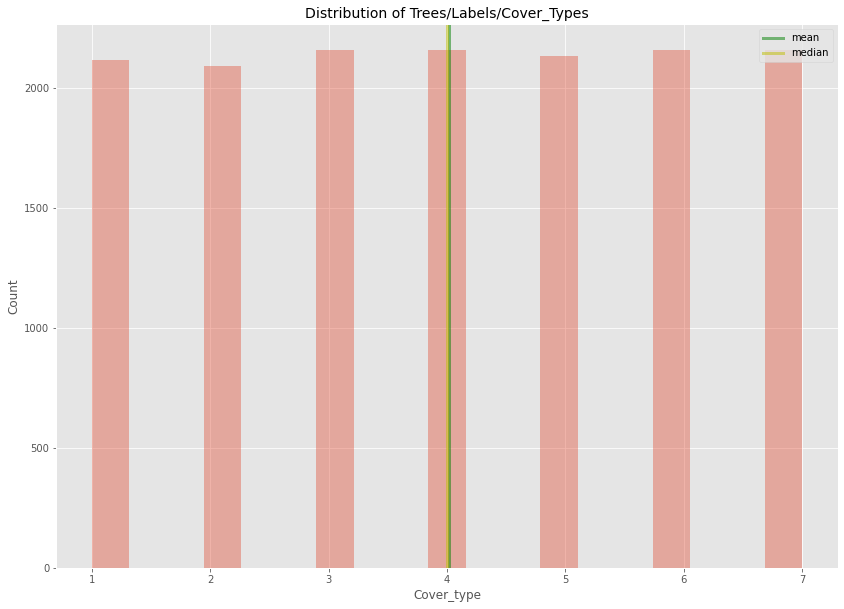

In [13]:
# Gràfic

# set the plot size
figsize(14,10)

# set the histogram, mean and median
sns.distplot(trees["Cover_type"], kde=False)
plt.axvline(x=trees.Cover_type.mean(), linewidth=3, color='g', label="mean", alpha=0.5)
plt.axvline(x=trees.Cover_type.median(), linewidth=3, color='y', label="median", alpha=0.5)

# set title, legends and labels
plt.xlabel("Cover_type")
plt.ylabel("Count")
plt.title("Distribution of Trees/Labels/Cover_Types", size=14)
plt.legend(["mean", "median"])


Veiem que aproximadament hi ha el mateix nombre d'arbres de cada tipus de
'Cover_type', la distribució és molt uniforme. Els tipus són:

1) Spruce/Fir

2) Lodgepole Pine

3) Ponderosa Pine

4) Cottonwood/Willow

5) Aspen

6) Douglas-fir

7) Krummholz

Ara mirem com és la distribució de 'Cover_type' per cada una de les 'Wilderness Area'

<ipython-input-14-5780ebe99929>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trees['WAT'] = (trees.iloc[:, 11:15] == 1).idxmax(1)


Text(0.5, 1.0, 'Density of Cover Types Among Different Wilderness Areas')

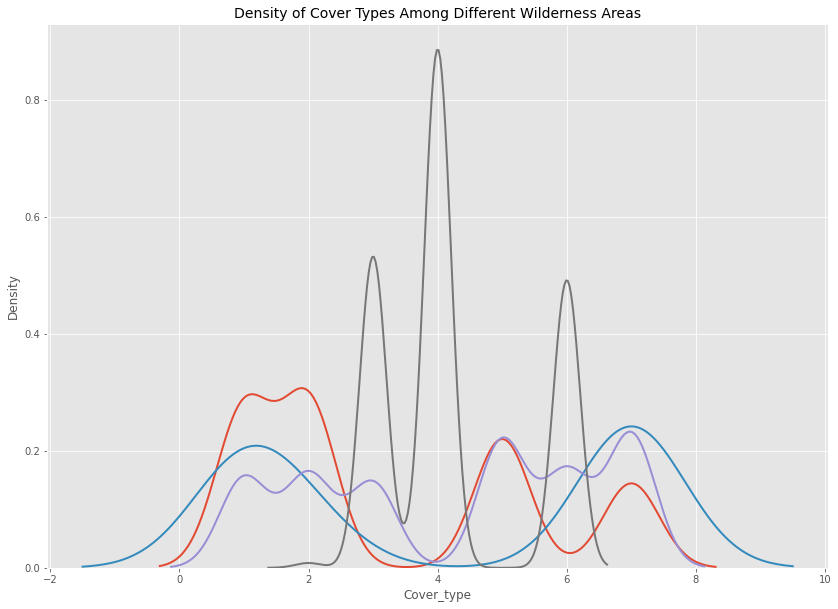

In [14]:
# Gràfic

# Create one column as Wilderness_Area_Type and represent it as categorical data
trees['WAT'] = (trees.iloc[:, 11:15] == 1).idxmax(1)

#list of wilderness areas
wilderness_areas = sorted(trees['WAT'].value_counts().index.tolist())

# distribution of the cover type in different wilderness areas
figsize(14,10)

# plot cover_type distribution for each wilderness area
for area in wilderness_areas:
    subset = trees[trees['WAT'] == area]
    sns.kdeplot(subset["Cover_type"], label=area, linewidth=2)

# set title, legends and labels
plt.ylabel("Density")
plt.xlabel("Cover_type")
plt.title("Density of Cover Types Among Different Wilderness Areas", size=14)


Veiem que la distribució de 'Cover_type' varia bastant segons la 'Wilderness Area',
per exemple, veiem que 'Cover_type' 4 és molt present a l'area 4 (vermell) i pràctimanet
no apareix a la resta.
El que podem esbrinar a partir del gràfic:
* Cover_type 1, 2, 7 són majoritariament presents a les arees 1,2 and 3.
* Cover_type 3 és bastant més present a l'area 4 que a la resta.
* Cover_type 4 sembla que només es troba a l'area 4.
* És igual de probable trobar arbres de Cover_Type 5 a l'area 1 i a la 3.
* Arbres de Cover_type 6 es poden trobar a totes les arees, éssent menys present
a l'area 1 i més present a l'area 4.

Un altre aspecte que hem de considerar és la relació entre el 'Soil_type' i el 'Cover_type'
Al fer-ho cal tenir em compte que una 'Wilderness area' pot ser que tingui diversos
'Soil_type'

In [15]:
def split_numbers_chars(row):
    '''This function fetches the numerical characters at the end of a string
    and returns alphabetical character and numerical chaarcters respectively'''
    head = row.rstrip('0123456789')
    tail = row[len(head):]
    return head, tail

def reverse_one_hot_encode(dataframe, start_loc, end_loc, numeric_column_name):
    ''' this function takes the start and end location of the one-hot-encoded column set and numeric column name to be created as arguments
    1) transforms one-hot-encoded columns into one column consisting of column names with string data type
    2) splits string column into the alphabetical and numerical characters
    3) fetches numerical character and creates numeric column in the given dataframe
    '''
    dataframe['String_Column'] = (dataframe.iloc[:, start_loc:end_loc] == 1).idxmax(1)
    dataframe['Tuple_Column'] = dataframe['String_Column'].apply(split_numbers_chars)
    dataframe[numeric_column_name] = dataframe['Tuple_Column'].apply(lambda x: x[1]).astype('int64')
    dataframe.drop(columns=['String_Column','Tuple_Column'], inplace=True)

Aquestes funnció converteixen totes les columnes de valor binari d'un rang donat en una
sola columna de valor numèric. El que farem serà convertir les 40 columnes de valor categòric
de soil_type a una de sola amb valor numèric.

In [16]:
reverse_one_hot_encode(trees, 16, 56, "Soil_type")


<ipython-input-15-bb6591a3c688>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['String_Column'] = (dataframe.iloc[:, start_loc:end_loc] == 1).idxmax(1)
<ipython-input-15-bb6591a3c688>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['Tuple_Column'] = dataframe['String_Column'].apply(split_numbers_chars)
<ipython-input-15-bb6591a3c688>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Anem a mostrar per cada 'Wilderness area', quina és la relació entre 'Soil_type' i
'Cover_type'

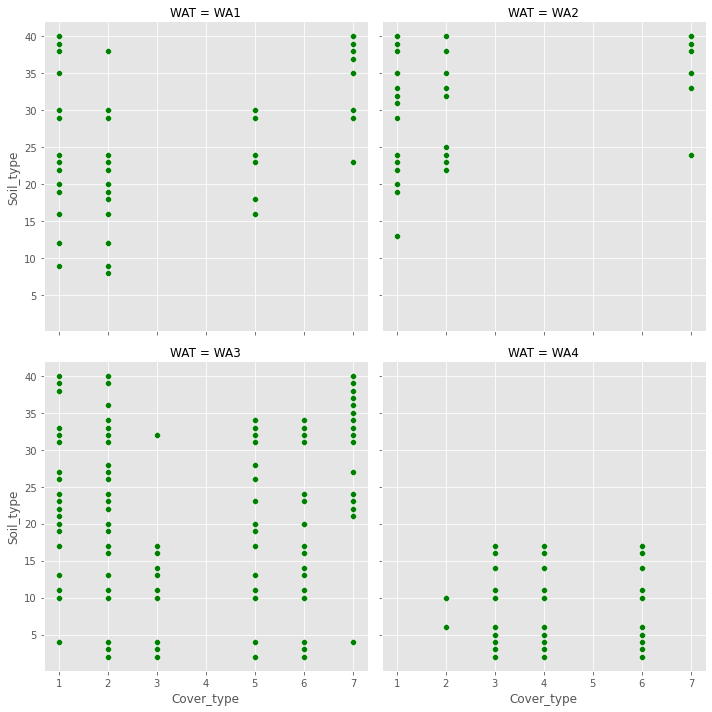

In [17]:

# Gràfic

# plot relationship of soil type and cover type among different wilderness areas
g = sns.FacetGrid(trees, col="WAT",
                  col_wrap=2, height=5, col_order=wilderness_areas)
g = g.map(plt.scatter,"Cover_type", "Soil_type", edgecolor="w", color="g")


Veiem que a l'area 3 hi ha més diversitat en 'Soil_type' i 'Cover_type' que la resta,
El sòl de l'area 4 és de tipus 'Soil_type' 1 fins al 20,
Els 'Cover_type' 1 i 2 créixen a gairebé tots els 'Soil_type', el 5 i el 6 també, excepte
a tipus 35-40
Els arbres de 'Cover_type' 3 i 4 créixen en 'Soil_type' de l'1 al 17/18,
Els arbres de tipus 7 sembla que créixen en sòls de tipus 20-40.


Estudiem també quina correlació hi ha entre les variables continues: elevació, distància,
hombra de la muntanya, pendent.

Per fer-ho es defineix una funció que calcula la correlació, i es mostra una matriu de gràfics,
la diagonal serà l'histograma de cada variable, el triàngle inferior gràfics de densitat i el
triàngle superior serà un graf de dispersió

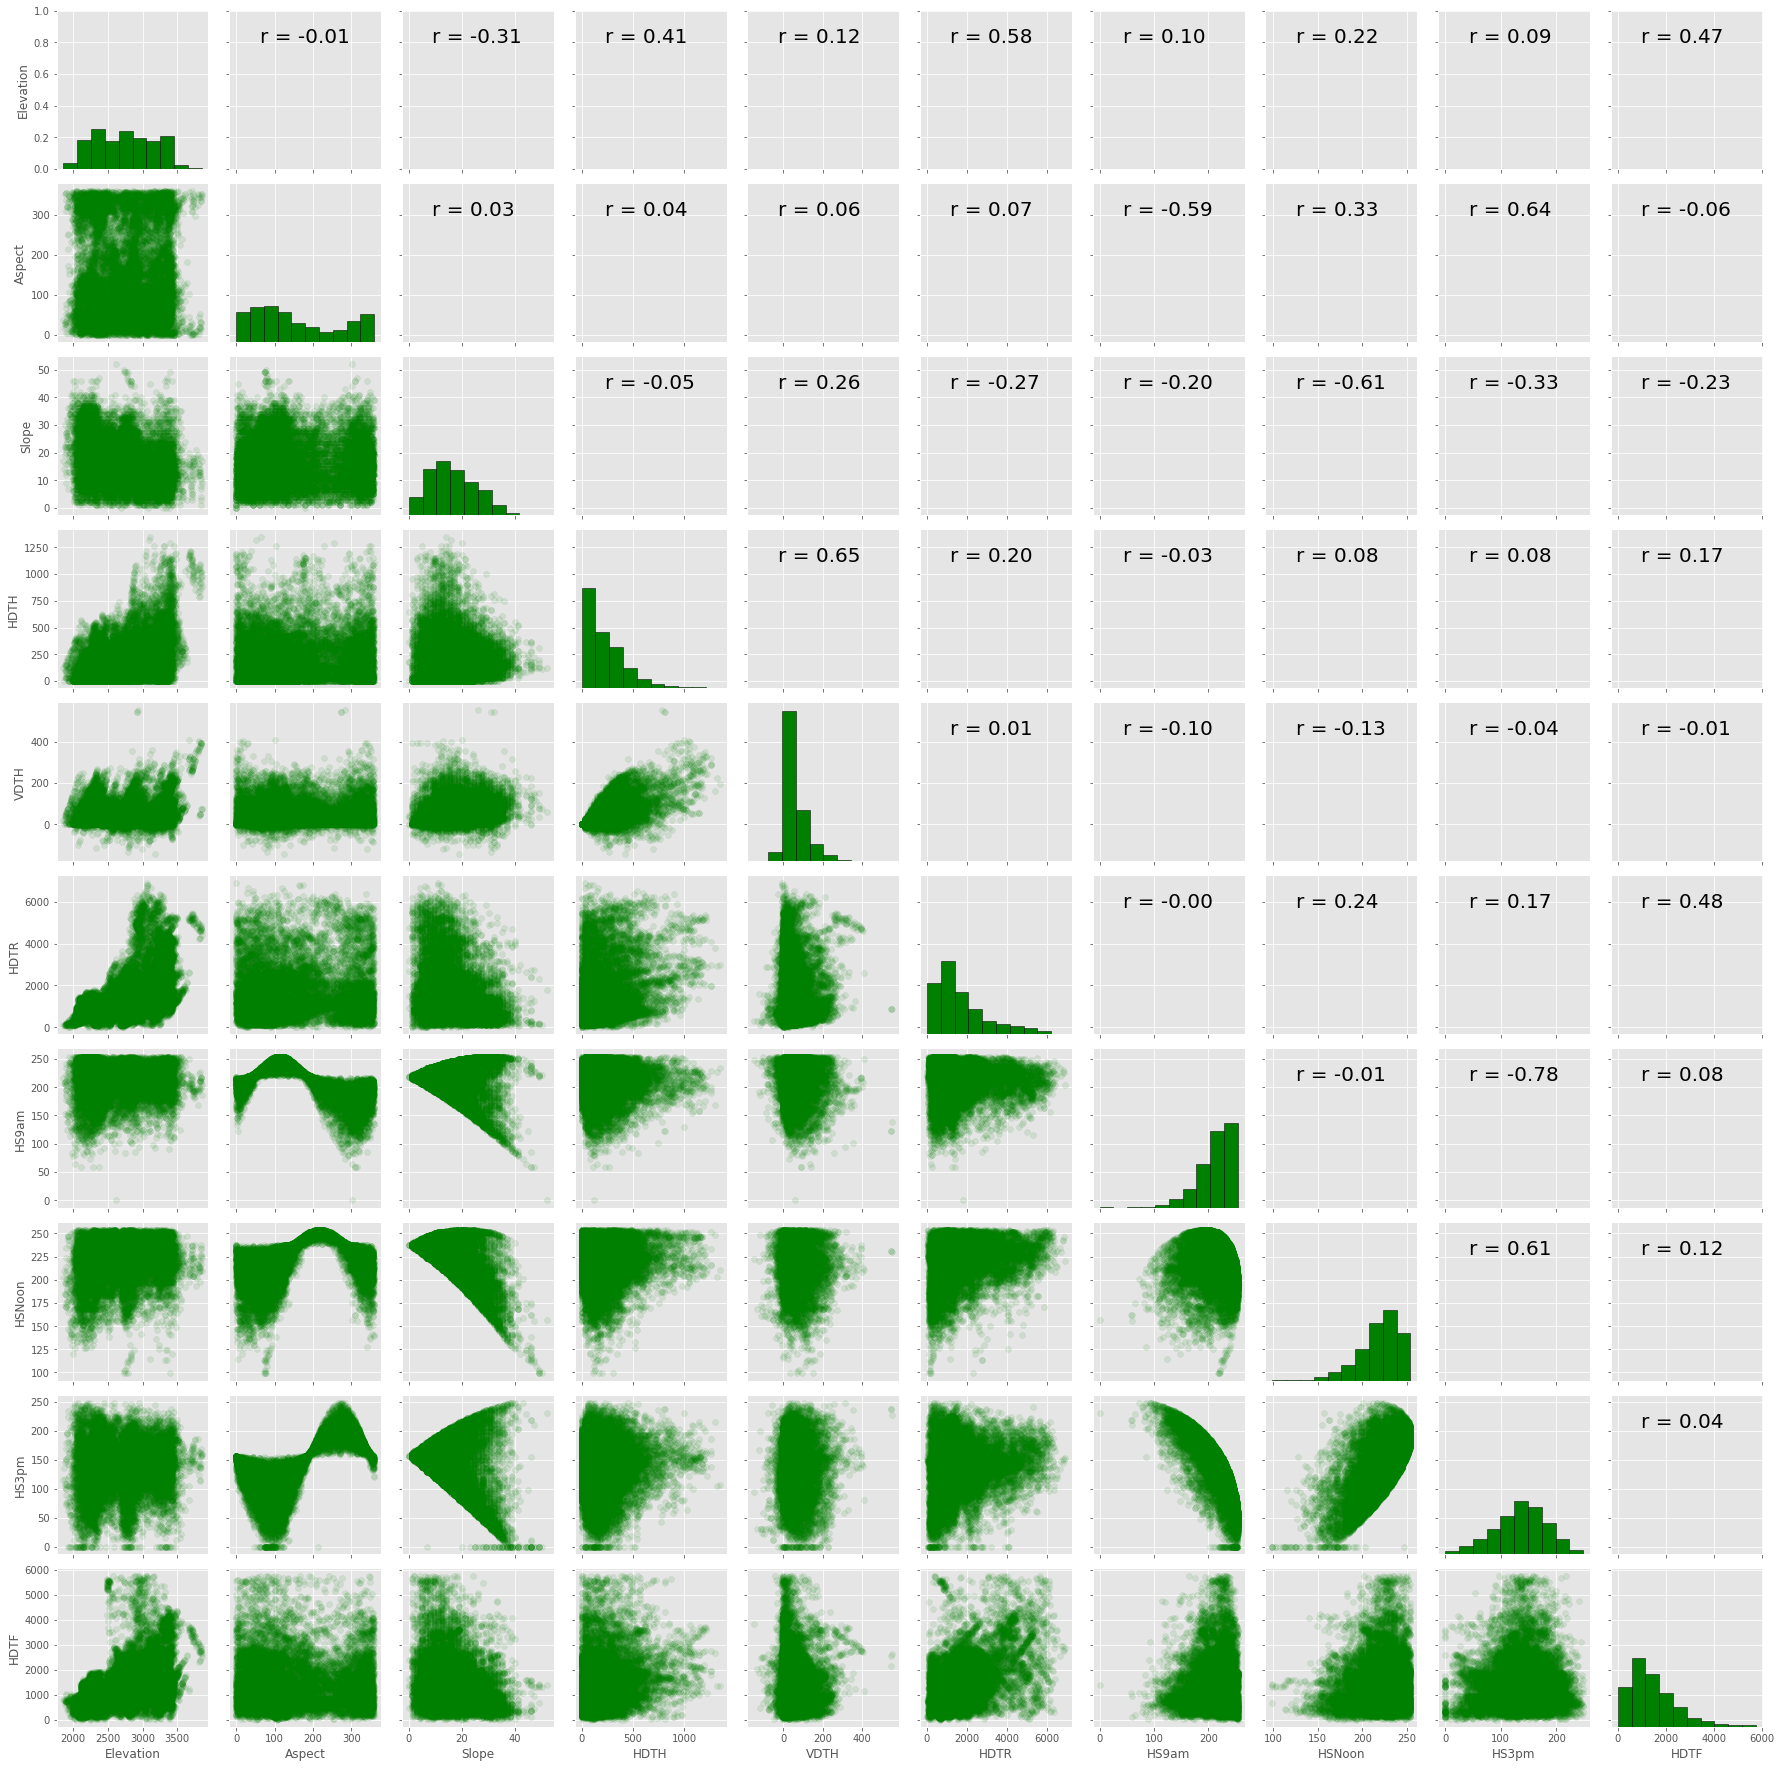

In [18]:
# store continious variables in a list
continuous_variables = trees.columns[1:11].tolist()

# Function to calculate correlation coefficient between two columns
def corr_func(x, y, **kwargs):
    r = np.corrcoef(x, y)[0][1]
    ax = plt.gca()
    ax.annotate("r = {:.2f}".format(r),
                xy=(.2, .8), xycoords=ax.transAxes,
                size = 20)

# Create the pairgrid object
grid = sns.PairGrid(data = trees[continuous_variables])

# Upper is a correlation and kdeplot
grid.map_upper(corr_func);

# Diagonal is a histogram
grid.map_diag(plt.hist, color = 'green', edgecolor = 'black')

# Bottom is scatter plot
grid.map_lower(plt.scatter, color = 'green', alpha = 0.1)


**Distribucions**

HS9am i HSNoon tenen una distribució esbiaixada a l'esquerra.

Les distàncies horitzontals presenten una distribució amb biaix a la dreta.

Elevation sembla tenir una distribució uniforme.

**Relacions entre les variables**

Elevation té una tendència positiva amb les diverses distàncies (VDTH,HDTH,HDTF,HDTR).

A més Aspect, més HSNoon i HS3pm.

Slope (pendent) té una tendència negativa amb amb Elevation, HDTR, HS totes, i HDTF.

HDTH presenta una tendència positiva amb la resta de distàncies (VDTH,HDTF,HDTR)

VDTH-Slope i VDTH-HDTH presenten una relació lineal.

A més HDTR, més HDTF i menys Slope.

HS9am té una tendència negativa amb HS3pm, i a més HS9am més Elevation.

HSNoon presenta una tendència positiva amb Elevation, Aspect, HDTR, HDTF i HS3pm.

**Correlacions lineals**
Podem observar les següents relacions entre parells de variables.
* HSNoon amb HS3pm
* HS3pm amb HS9am
* VDTH amb HDTH
* Elevation amb Slope

Estudiem aquestes correlacions respecte el 'Cover_type'

Text(0.5, 1.0, 'Elevation VS Slope')

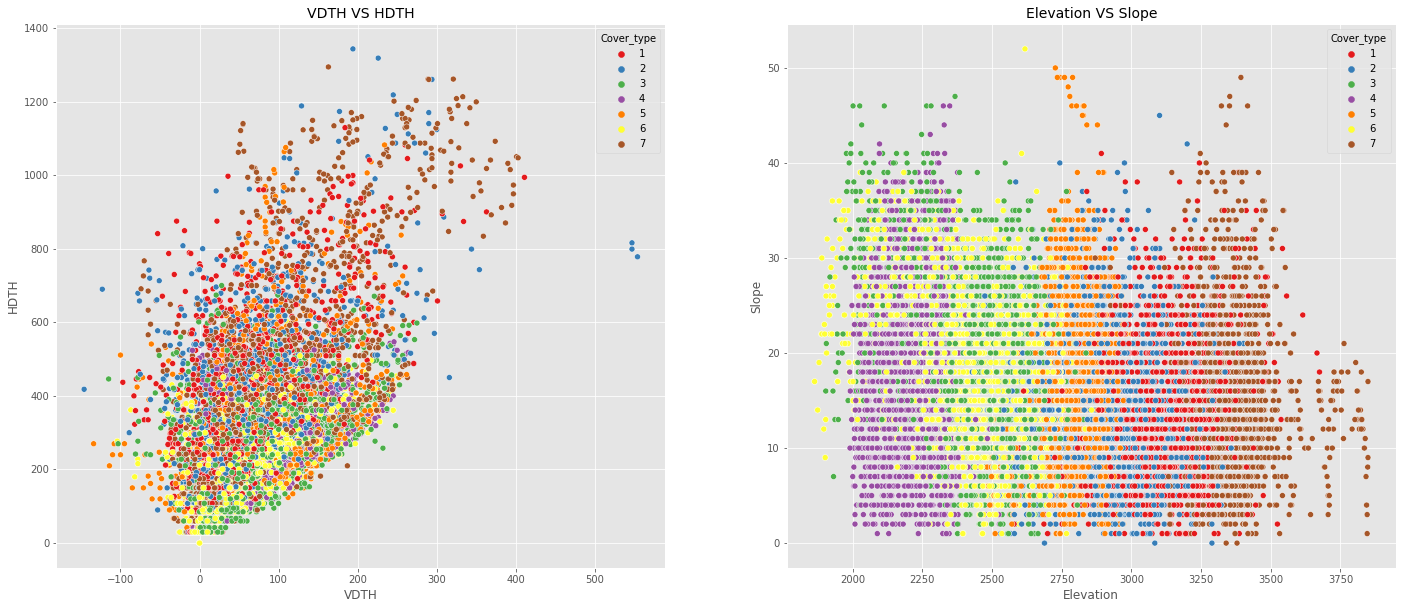

In [19]:
figsize(24,10)

# plot the first subplot
plt.subplot(1,2,1)
sns.scatterplot(x="VDTH", y="HDTH",
                hue="Cover_type", data=trees,
                legend="full", hue_norm=(0,8), palette="Set1")
plt.title("VDTH VS HDTH", size=14)

# plot the second subplot
plt.subplot(1,2,2)
sns.scatterplot(x="Elevation", y="Slope",
                hue="Cover_type", data=trees,
                legend="full", hue_norm=(0,8), palette="Set1")
plt.title("Elevation VS Slope", size=14)


Text(0.5, 1.0, 'HS9am VS HS3pm')

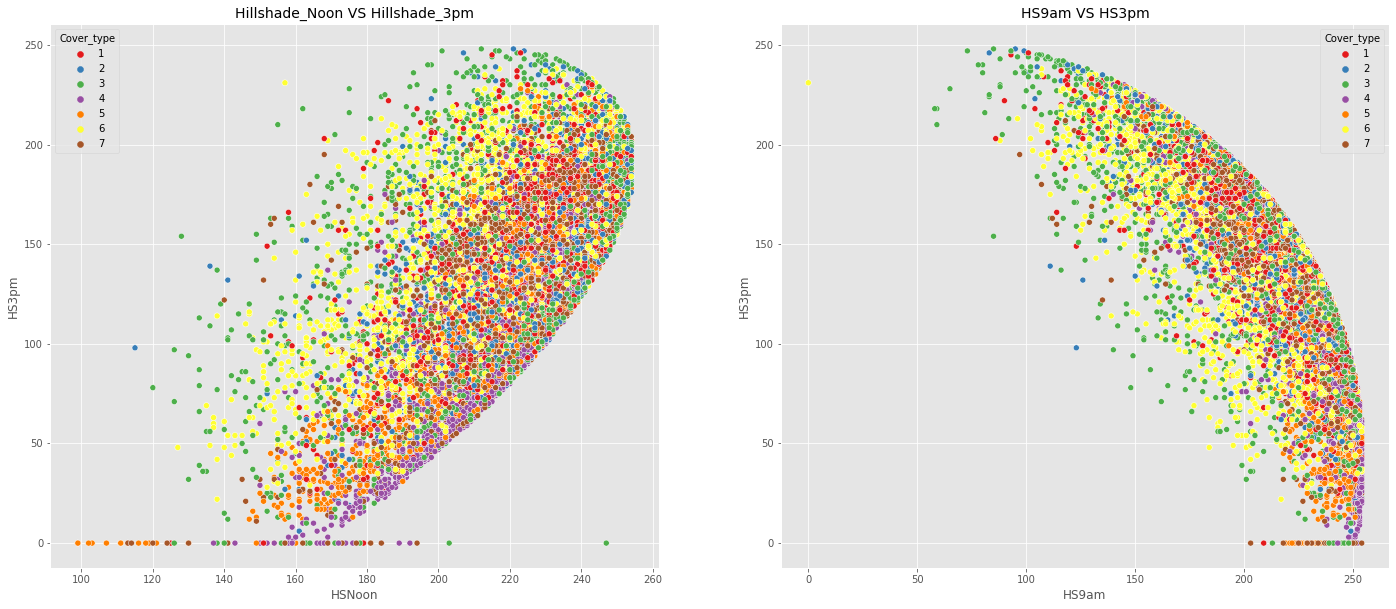

In [20]:

figsize(24,10)

# plot the first subplot
plt.subplot(1,2,1)
sns.scatterplot(x="HSNoon", y="HS3pm",
                hue="Cover_type", data=trees,
                legend="full", hue_norm=(0,8), palette="Set1")
plt.title("Hillshade_Noon VS Hillshade_3pm", size=14)

# plot the second subplot
plt.subplot(1,2,2)
sns.scatterplot(x="HS9am", y="HS3pm",
                hue="Cover_type", data=trees,
                legend="full", hue_norm=(0,8), palette="Set1")
plt.title("HS9am VS HS3pm", size=14)


Al tenir les variables HS relacionades entre si de dos a dos (HSNoon amb HS3pm i HS3pm amb HS9am)
és interessant eliminar-ne una. Per triar quina eliminarem usarem el quoefficient de Pearson.
Convertirem 'Soil_type' a un valor numèric.

Text(0.5, 1.0, 'Correlació de Pearson entre els atributs i Numeric soil type')

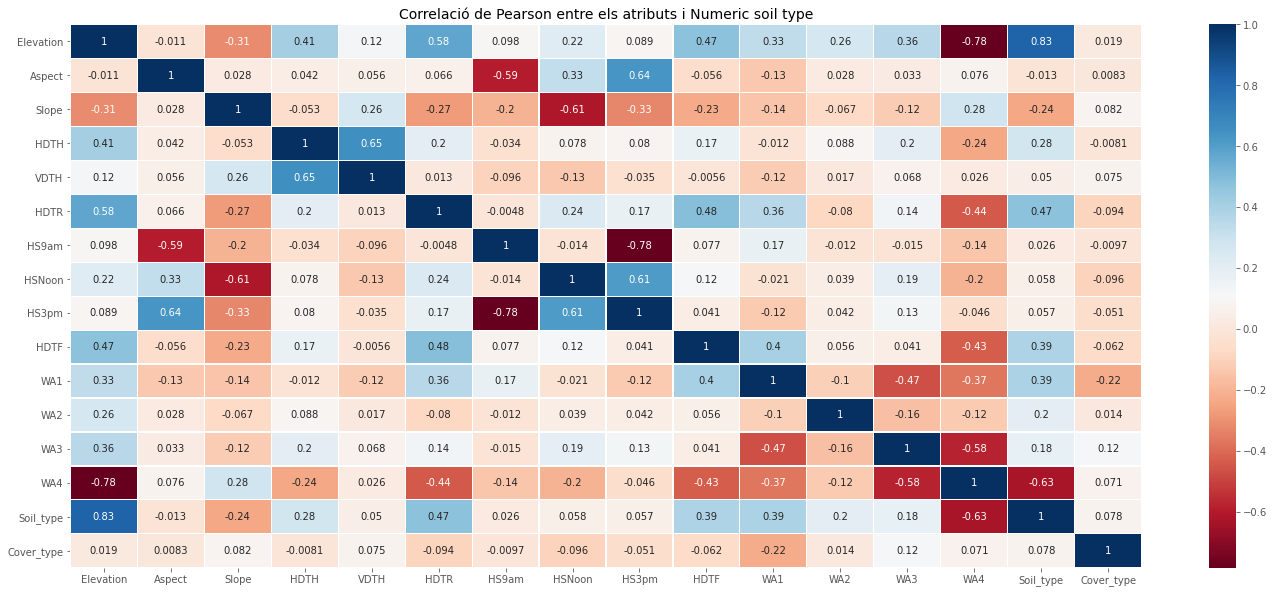

In [21]:
# make a list of numeric features and create a dataframe with them
all_features_w_label = continuous_variables + wilderness_areas + ["Soil_type"] + ["Cover_type"]
trees_w_numeric_soil= trees[all_features_w_label]

# pearson coefficients with numeric soil type column
correlations = pd.DataFrame(trees_w_numeric_soil.corr())
figsize=(16,14)

# plot the heatmap
colormap = plt.cm.RdBu
sns.heatmap(correlations,linewidths=0.1,
            square=False, cmap=colormap, linecolor='white', annot=True)
plt.title('Correlació de Pearson entre els atributs i Numeric soil type', size=14)


De les 3 ombres la que és menys significativa és HS9am, per tant serà la que hauriem d'eliminar.

## Conclusions sobre les dades
La distribució de 'Cover_type' és molt uniforme, per tant si entrenem un
model de ML per a classificar 'Cover_type' tindrà les mateixes opcions per
a aprendre patrons de tots els tipus, molt bona noticia ja que això minimitzarà/eliminarà
'underfitting'

Cada 'Wilderness area' conté uns arbres específics. El 'Cover_type' 4 sembla que
només aparéix a l'area 4, els 'Cover_type' 1, 2, 5 i 6 créixen a gairebé tots
els tipus de sòl, i altres tipus d'arbres preferèixen tipus específics de sòl.

'Soil_type' com a valor numèric té millor correlació amb 'Cover_type' que no
pas de forma 'one hot encoded' (variables binàries, només una "true" per cada fila)

El quoeficient de Pearson de les variables respecte 'Cover_type' pren valors
d'entre -0.2 i 0.1

## Feature Selection

A part d'eliminar/transformar columnes ('Soil_type' numèric, eliminar HS9am) també
es poden afegir noves columnes a partir de les existents que poden fer que
el dataset faciliti més l'aprenentatge del nostre model de ML.

Afegiré combinacions d'elevació i distàncies, i després afegiré les
les arrels quadrades de les variables amb un rang positiu, ja que
pot ajudar amb les distribucions esbiaixades.

* Elevation amb VDTH
* HDTH amb HDTF
* HDTH amb HDTR
* HDTF amb HDTR
* Distància euclidea a hidrologia (HDTH amb VDTH), EDTH

In [22]:
# add columns

# Distància euclidea a hidrologia
trees_w_numeric_soil['EDTH'] = (trees_w_numeric_soil['HDTH']**2 +
                                                           trees_w_numeric_soil['VDTH']**2)**0.5
# Mitjana d'Elevation i VDTH
trees_w_numeric_soil['MEVDTH'] = (trees_w_numeric_soil['Elevation'] +
                                                                      trees_w_numeric_soil['VDTH'])/2
# Mitjana de HDTH i HDTF
trees_w_numeric_soil['MDHF'] = (trees_w_numeric_soil['HDTH'] +
                                                              trees_w_numeric_soil['HDTF'])/2
# Mitjana de HDTH i HDTR
trees_w_numeric_soil['MDHR'] = (trees_w_numeric_soil['HDTH'] +
                                                            trees_w_numeric_soil['HDTR'])/2
# Mitjana de HDTR i HDTF
trees_w_numeric_soil['MDFR'] = (trees_w_numeric_soil['HDTF'] +
                                                             trees_w_numeric_soil['HDTR'])/2

<ipython-input-22-afa20a6cb737>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trees_w_numeric_soil['EDTH'] = (trees_w_numeric_soil['HDTH']**2 +
<ipython-input-22-afa20a6cb737>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trees_w_numeric_soil['MEVDTH'] = (trees_w_numeric_soil['Elevation'] +
<ipython-input-22-afa20a6cb737>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [23]:
# add sqrt transformed columns to the trees_w_numeric_soil dataframe
for col in trees_w_numeric_soil.columns:
    if trees_w_numeric_soil[col].min() >= 0:
        if col == 'Cover_type':
            next
        else:
            trees_w_numeric_soil['sqrt_' + col] = np.sqrt(trees_w_numeric_soil[col])

<ipython-input-23-f768a94f4b95>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trees_w_numeric_soil['sqrt_' + col] = np.sqrt(trees_w_numeric_soil[col])


Un cop tenim les noves columnes hauriem de mirar de nou els quoeficients de
Pearson, per veure si hem afegit informació útil.

In [24]:
correlations_transformed = pd.DataFrame(trees_w_numeric_soil.corr())
correlations_transformed = pd.DataFrame(correlations_transformed["Cover_type"]).reset_index()

# format, and display sorted correlations_transformed
correlations_transformed.columns = ["Feature", "Correlation with Cover_type"]
correlations_transformed = (correlations_transformed[correlations_transformed["Feature"] != "Cover_type"]
                .sort_values(by="Correlation with Cover_type", ascending=True))
display(correlations_transformed)

,Feature,Correlation with Cover_type
30,sqrt_WA1,-0.220713
10,WA1,-0.220713
7,HSNoon,-0.095848
27,sqrt_HSNoon,-0.095399
5,HDTR,-0.094212
20,MDFR,-0.092875
19,MDHR,-0.091495
39,sqrt_MDFR,-0.089852
38,sqrt_MDHR,-0.080075
25,sqrt_HDTR,-0.076923


Les variables que ens quedarem, apart de les prèviament existents, serán:
sqrt_HDTH en comptes de HDTH, sqrt_MDHR, sqrt_EDTH, MEVDTH, MDFR, MDHF. També
eliminarem HS9am com he comentat abans.

In [25]:
transformed_features = ['sqrt_HDTH', 'sqrt_MDHR', 'sqrt_EDTH', 'MEVDTH',
                        'MDFR', 'MDHF']

all_features =  (['Elevation', 'Aspect', 'Slope', 'VDTH', 'HDTR',
                  'HSNoon', 'HS3pm', 'HDTF' ] + wilderness_areas +
                 ['Soil_type'] + transformed_features)


Separem el 'target' és a dir 'Cover_type', el tipus d'arbre, dels seus atributs.

In [26]:
trees_training = trees_w_numeric_soil[all_features]
labels_training = trees_w_numeric_soil["Cover_type"]

Ara que ja hem transformat les dades calcularem de nou la precisió del
SVC lineal, per fer-ho usarem la mateixa funció que al principi.

In [27]:
# create scaler
scaler = StandardScaler()

# apply normalization to training set and transform training set
X  = scaler.fit_transform(trees_training, labels_training)
y = labels_training

clf = SVC(kernel='linear')

acc = fit_evaluate_model(clf,X,y,5)

print("Puntuació del svc després d'aplicar 'feature selection: ", acc)

Puntuació del svc després d'aplicar 'feature selection:  0.6667388981153713


La precisió del SVC després d'haver fet feature selection ha augmentat 3 punts,
però potser si mantenim les columnes de 'Soil_type_x' podem obtenir millors resultats

In [28]:
svc_features = (['Elevation', 'Aspect', 'Slope', 'VDTH', 'HDTR',
                  'HSNoon', 'HS3pm', 'HDTF' ] + wilderness_areas +
                 soil_types)

svc_train = trees[svc_features]
svc_train[transformed_features] = trees_w_numeric_soil[transformed_features]

display(svc_train.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14988 entries, 11 to 15119
Data columns (total 58 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Elevation     14988 non-null  int64  
 1   Aspect        14988 non-null  int64  
 2   Slope         14988 non-null  int64  
 3   VDTH          14988 non-null  int64  
 4   HDTR          14988 non-null  int64  
 5   HSNoon        14988 non-null  int64  
 6   HS3pm         14988 non-null  int64  
 7   HDTF          14988 non-null  int64  
 8   WA1           14988 non-null  int64  
 9   WA2           14988 non-null  int64  
 10  WA3           14988 non-null  int64  
 11  WA4           14988 non-null  int64  
 12  Soil_type_1   14988 non-null  int64  
 13  Soil_type_2   14988 non-null  int64  
 14  Soil_type_3   14988 non-null  int64  
 15  Soil_type_4   14988 non-null  int64  
 16  Soil_type_5   14988 non-null  int64  
 17  Soil_type_6   14988 non-null  int64  
 18  Soil_type_7   14988 non-n

C:\Users\Rubén\AppData\Roaming\Python\Python38\site-packages\pandas\core\frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


None

Ara el nostre dataset conté les mateixes columnes que hem obtingut
després d'aplicar feature selection, amb la diferència que tornem a tenir el
'soil_type' com a dades categòriques.

In [29]:
X  = scaler.fit_transform(svc_train, labels_training)
y = labels_training

clf = SVC(kernel='linear')

score_svc = fit_evaluate_model(clf,X,y,5)

print("Puntuació del SVC amb feature selection i soil type categòric: ", score_svc)

Puntuació del SVC amb feature selection i soil type categòric:  0.6702097917352532


La precisió augmenta aproximadament un punt al tenir 40 dades categòriques 'Soil_type_x'
en comptes de tenir una dada numèrica.

El blog compara la precisió dels algoritmes Knn, Gradient Boost Machine (Light i Extra)
i Random Forest (per defecte i Extra Trees), i troba que el que té més precisió és Extra Trees.
Del SVC hem calculat la puntuació mitjana d'aplicar 5-fold Cross Validation, per tant per
comparar el SVC amb l'Extra Trees també calcularem la puntuació mitjana de l'Extra Trees.

In [30]:
X = trees_training
y = labels_training

clf = ExtraTreesClassifier()
score_xtc = fit_evaluate_model(clf,X,y,5)

print("Puntuació del Extra Trees Classifier amb feature selection:",score_xtc)

Puntuació del Extra Trees Classifier amb feature selection: 0.8197939990245973


Sembla ser que Extra Trees té una precisió de prop de 0.82, que és bastant superior
a la que he aconseguit amb el SVC. Tot i això, encara podem millorar el nostre SVC.
Fins ara hem vist el funcionament d'un SVC amb kernel lineal, és a dir que la funció de
decisió que fa servir és lineal. L'algoritme SVC d'sk-learn admet altres kernels (polinòmic,
exponencial, sigmoide), calcularé la precisió d'un SVC amb kernel exponencial (Radial Basis
Function, rbf), usant soil_type numèric i categòric.


In [31]:
X_soil_numeric  = scaler.fit_transform(trees_training, labels_training)
X_soil_categoric = scaler.fit_transform(svc_train, labels_training)
y = labels_training

clf = SVC(kernel='rbf')

score_svc1 = fit_evaluate_model(clf,X_soil_numeric,y,5)
score_svc2 = fit_evaluate_model(clf,X_soil_categoric,y,5)

print("Puntuació del SVC amb kernel 'rbf': \n\t Usant soil_type numèric: ", score_svc1,
      "\n\tUsant soil_type categòric", score_svc2)

Puntuació del SVC amb kernel 'rbf': 
	 Usant soil_type numèric:  0.7075061496898277 
	Usant soil_type categòric 0.6854880007870892


Amb kernel rbf s'obté millor precisió quan usem el 'Soil_type' numèric, 1.5 punts de
diferència. Així doncs les següents proves les faré amb un SVC de kernel rbf amb el
dataset que conté 'Soil_type' com a valor numèric.

El rbf té un paràmetre 'gamma' que ve a ser la inversa del radi d'influència
de les mostres agafades com a support vectors, a més el SVC en general
té un paràmetre C que regula la relació entre correcta classificació
i envers la maximització del marge de la funció de decisió. Quan més
petita C, major serà el marge i més simple serà la funció de decisió,
però tindra un cost en la precisió.

El següent que puc fer per a millorar la precisió del SVC és veure quins
són els valors òptims per a aquests paràmetres. ATENCIÓ PER QUÈ SERÀ UN
CÀLCUL MOLT COSTÓS, ja que faré 5-fold cross validation per cada combinació
de valors dels paràmetres. Els rangs que prendrán seràn: [0.001,0.01,0.1,1,10,100,1000]

In [42]:
C_range = [0.001,0.01,0.1,1,10,100,1000]
gamma_range = [0.001,0.01,0.1,1,10,100,1000]
param_grid = dict(gamma=gamma_range, C=C_range)
display(param_grid)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
grid = GridSearchCV(clf, param_grid=param_grid, cv=cv, n_jobs=-1, scoring="accuracy")
grid.fit(X, y)
best_params = grid.best_params_

#C = 100 i gamma = 0.1

{'gamma': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}

In [43]:
display(best_params)
display(grid.best_score_)
#display(grid.cv_results_)

{'C': 100, 'gamma': 0.1}

0.8489659773182121

{'mean_fit_time': array([19.91214437, 19.53295679, 19.0769752 , 18.1015852 , 16.95107117,
        27.83116384, 28.50974927, 15.71776152, 12.74890189, 12.10562339,
        17.04381523, 17.06316218, 28.68727221, 29.25156422, 10.40935946,
         6.61869822,  5.58127179, 15.37547712, 17.09148712, 29.60382304,
        29.55654936,  5.49849401,  3.75754833,  3.63886528, 15.42893353,
        19.86965699, 31.1897799 , 30.0063447 ,  3.52756352,  2.90363312,
         3.3422585 , 15.3790668 , 18.40636816, 29.53939366, 29.14165764,
         3.07417736,  3.52317696,  5.11751127, 15.01424274, 18.50630188,
        29.25156484, 28.78840117,  4.23527279,  8.76575341, 10.64353352,
        14.97135768, 18.27412353, 29.37204027, 28.07352791]),
 'std_fit_time': array([0.2583801 , 0.12403977, 0.60486647, 0.54592272, 1.01976733,
        0.35290807, 0.85218431, 1.14531745, 0.28684249, 0.09971132,
        0.32937369, 1.09144613, 0.6328454 , 0.72961609, 0.43245523,
        0.09957787, 0.07581164, 0.17190939, 

Amb el GridSearchCV podem veure quina seria la millor combinació d'aquests paràmetres.
Passant-li un rang per gamma i un per C, i passant-li també el classificador, ens calcula
quina és la puntuació del classificador per cada combinació de paràmetres. Amb un rang de
valors d'entre 0.001 i 1000 tant per gamma com per C, fent 5-fold cross validation trobem
que els valors amb millor resultat són gamma = 0.1 i C = 100.

Em fa l'efecte que GridSearchCV calcula la puntuació de forma diferent al cross_val_score,
per tant mirarem el cross_val_score del nostre classificador amb gamma = 0.1 i C = 100.
D'aquesta forma comparem "pomes amb pomes".

In [32]:
X = scaler.fit_transform(trees_training, labels_training)

y = labels_training

clf = SVC(kernel='rbf', gamma=0.1, C=100)

acc_final = fit_evaluate_model(clf,X,y,5)

millora_model = (acc_final/acc_inicial - 1)*100

millora_model = "{:.2f}".format(millora_model)

print("Puntuació del SVC amb kernel rbf, gamma = 0.1, C = 100: ", acc_final)
print("El model final de ML obtingut és ",millora_model,"% millor que l'inicial")

Puntuació del SVC amb kernel rbf, gamma = 0.1, C = 100:  0.7661505846518077
El model final de ML obtingut és  21.16 % millor que l'inicial


La precisió final obtinguda, segons el mètode cross_val_score, és de 0.7661505846518077.
La precisió inicial obinguda era prop de 0.6323412698412698.

El meu SVC segueix tenint pitjors resultats que l'Extra Trees, però tot i això,
he aconseguit augmentar significativament la precisió del SVC. Eliminant els extrems
d'una columna, aplicar 'feature selection', cambiar el kernel i calcular els
millors paràmetres per a aquest kernel, he augmentat prop de 13 punts la precisió
del nostre SVC. El model final és 21.16% millor que el model inicial.